In [46]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import mne
from mne.io import read_raw_bdf
from mne.datasets import eegbci
from mne import set_eeg_reference, pick_types, Epochs, concatenate_epochs
from mne.time_frequency import tfr_morlet, psd_array_welch

In [62]:
import os
import pickle

from mne.time_frequency import stft

dirname = 'data_preprocessed_python/'


# data: 40 x 40 x 8064 -- video/trial x channel x data
# labels: 40 x 4 -- trial x label (valence, arousal, dominance, liking)

num_trials = 40
num_channels = 32 
data_len = 8064

# X.shape: (n_signals, n_times)

X = np.zeros(shape=(num_trials, num_channels, data_len))
y = np.zeros(shape=(num_trials, 2)) # 2 - valence and arousal

for filename in os.listdir(dirname):
    file_path = os.path.join(dirname, filename)
    sbj = pickle.load(open(file_path, 'rb'), encoding='latin1')
    
    
    for i in range (0, num_trials):
        data = sbj['data'][i][:32] # 32 eeg channels, 8 additional parameters
        valence = sbj['labels'][i][0]
        arousal = sbj['labels'][i][1]
        X[i] = data
        y[i] = [valence, arousal]
        
print(X.shape, y.shape)

(40, 32, 8064) (40, 2)


In [63]:
X_train, X_test = X[:35], X[35:]
y_train, y_test = y[:35], y[35:]
train_data = [X_train, y_train]
test_data = [X_test, y_test]

In [64]:
from scipy.signal import stft

# Set the desired parameters for STFT
fs = 128  # Sampling frequency in Hz 
# (https://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html#prep: the data was downsampled to 128 Hz)
n_fft = 8064  # Number of FFT points
n_overlap = 128  # Number of overlapping samples

# Apply STFT to the EEG data
frequencies_train, time_points_train, stft_train_data = stft(X_train, fs=fs, nperseg=n_fft, noverlap=n_overlap)

frequencies_test, time_points_test, stft_test_data = stft(X_test, fs=fs, nperseg=n_fft, noverlap=n_overlap)

# Print the shape of the STFT data
print(stft_data.shape)

(8, 32, 2305, 3)


In [122]:
stft_train_data.shape

(35, 32, 4033, 3)

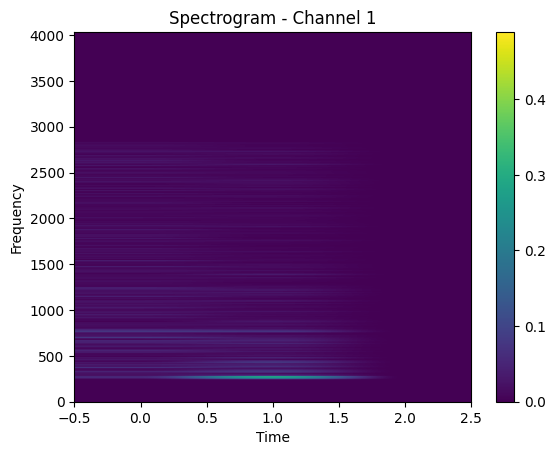

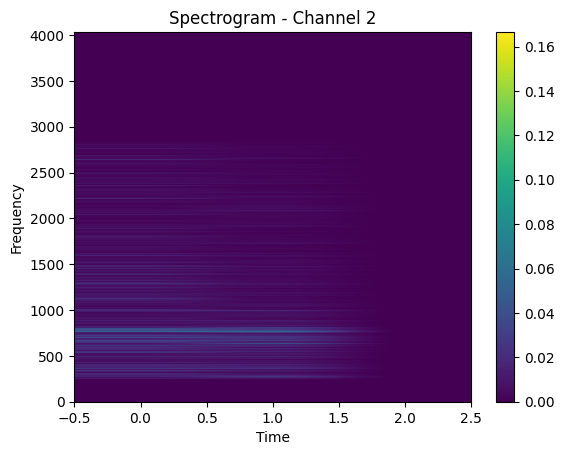

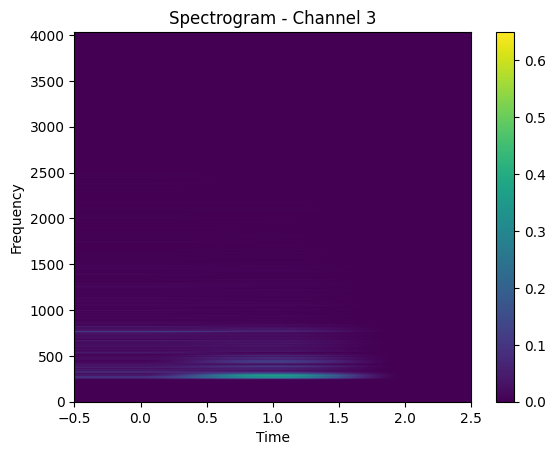

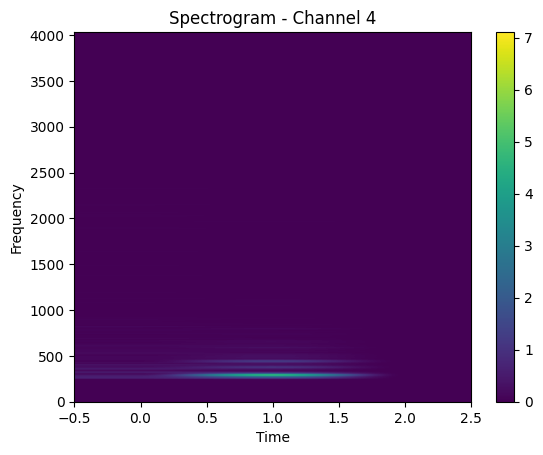

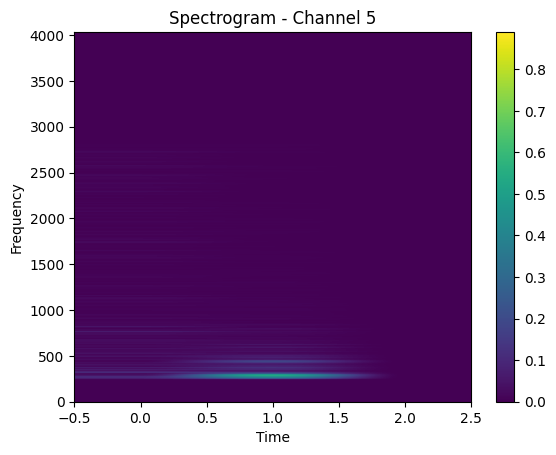

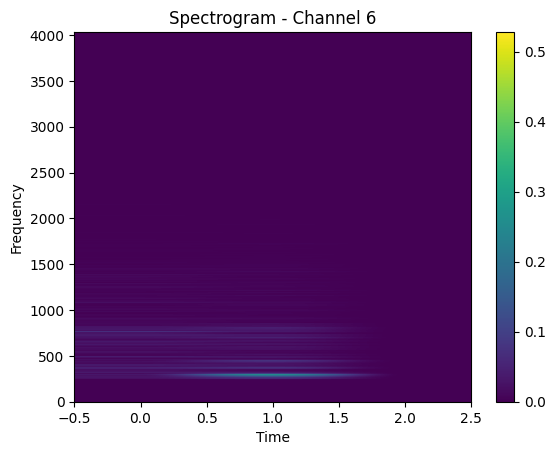

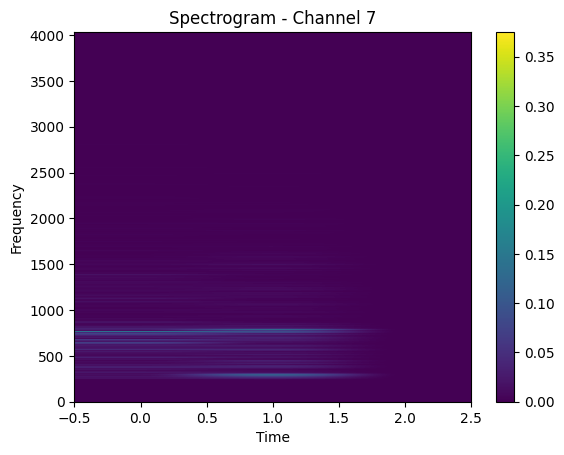

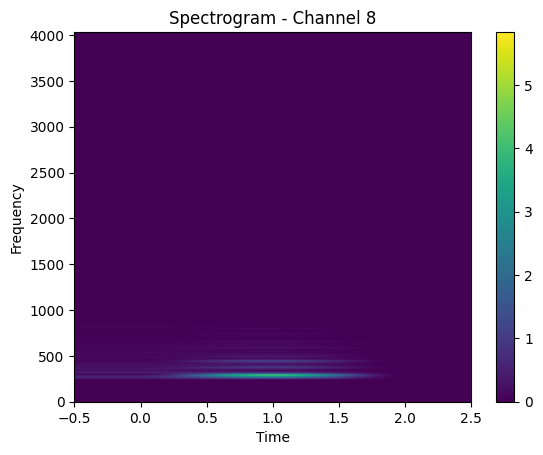

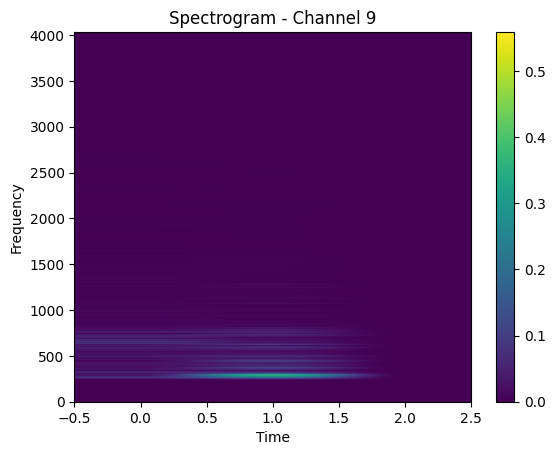

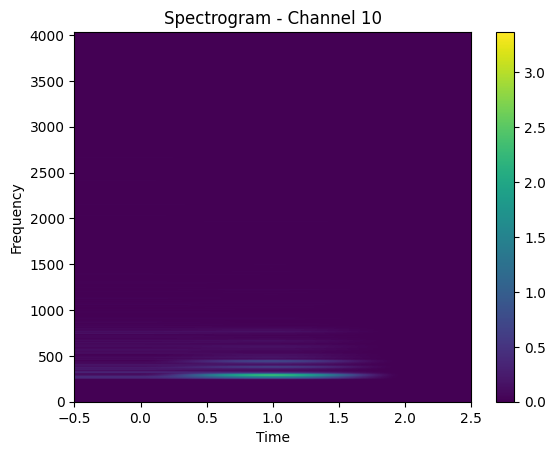

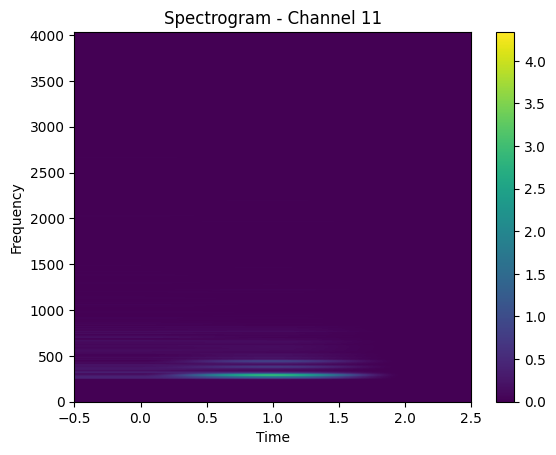

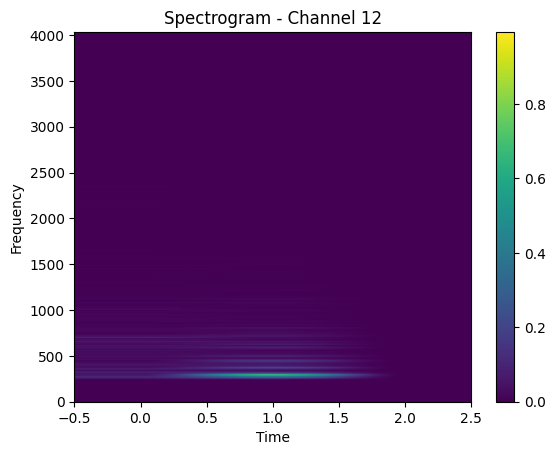

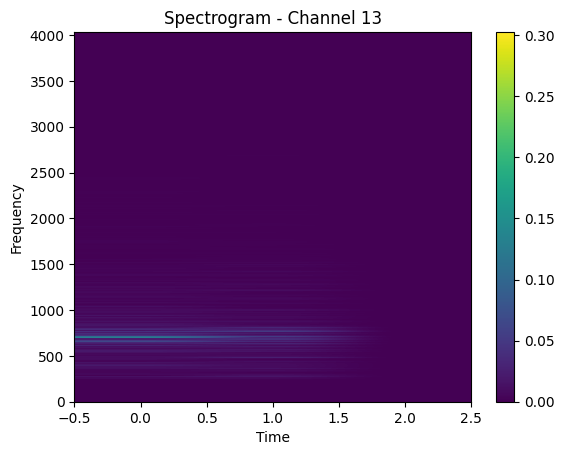

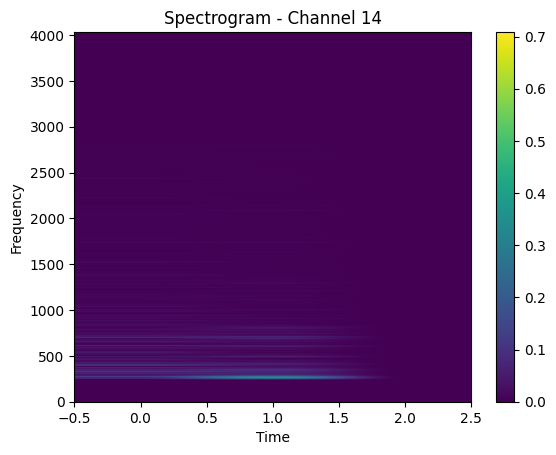

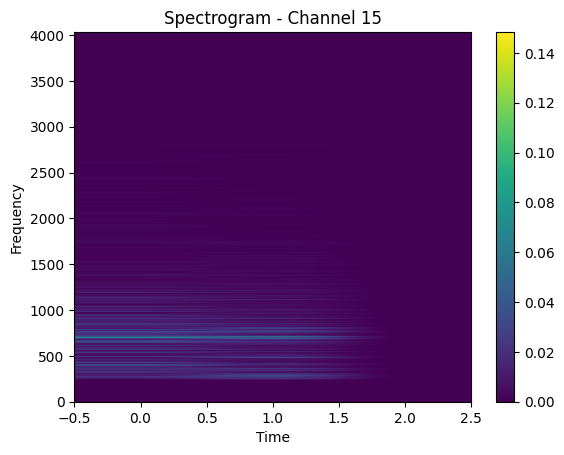

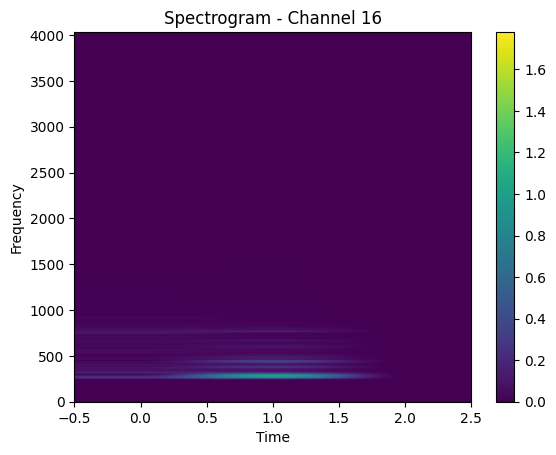

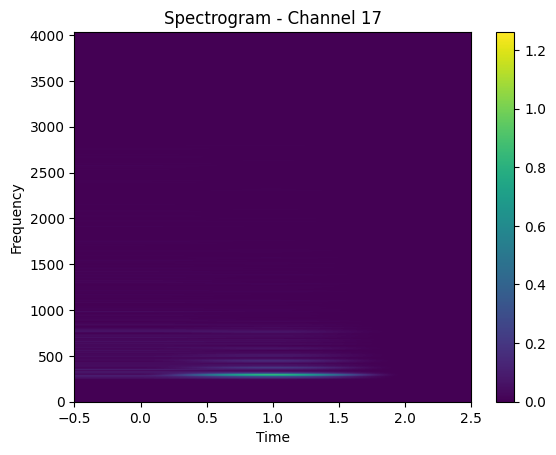

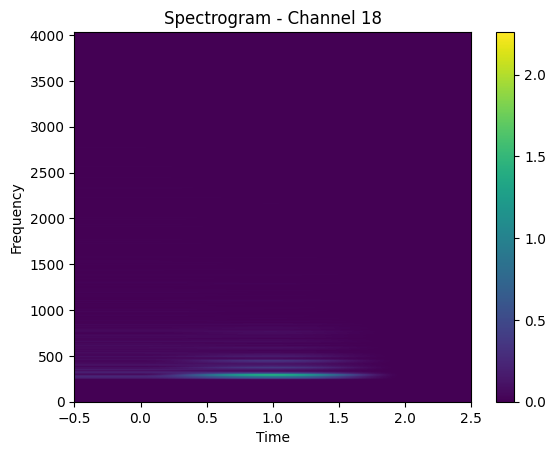

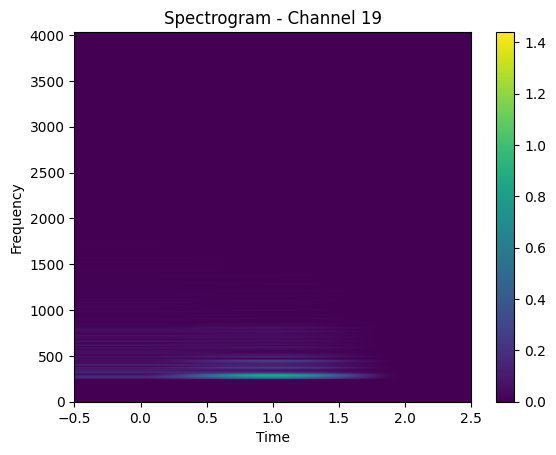

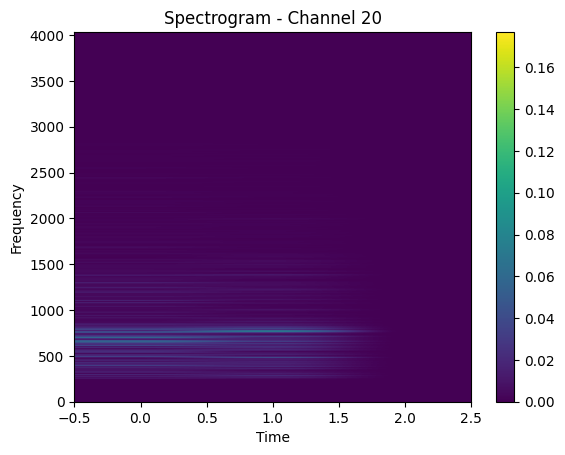

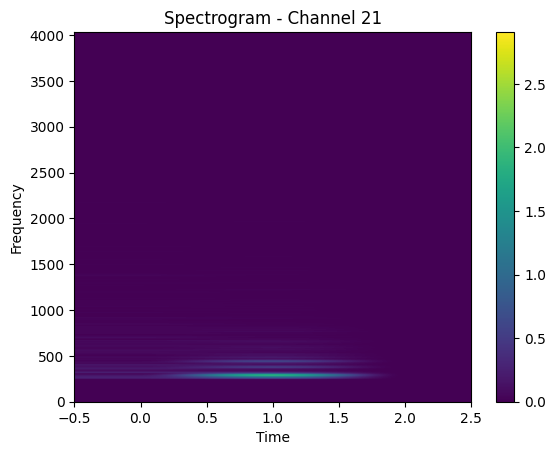

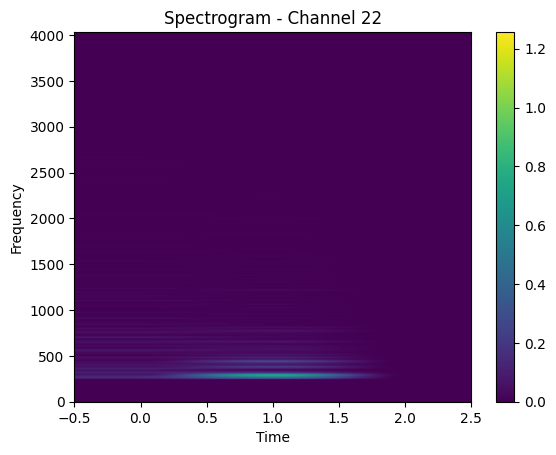

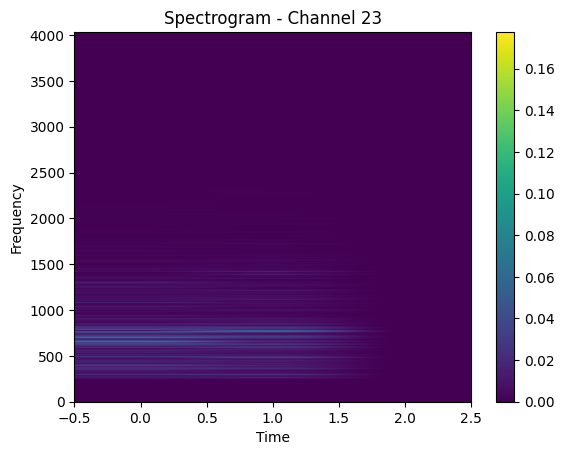

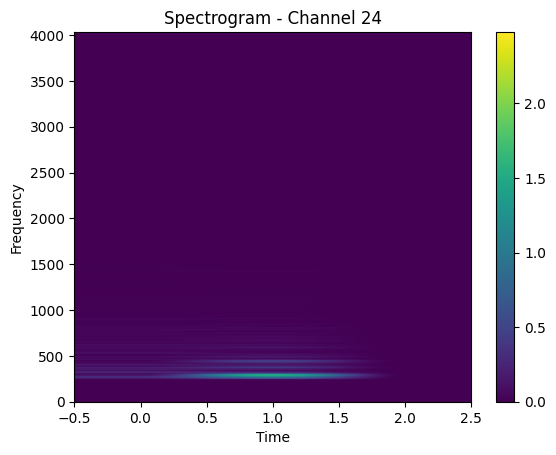

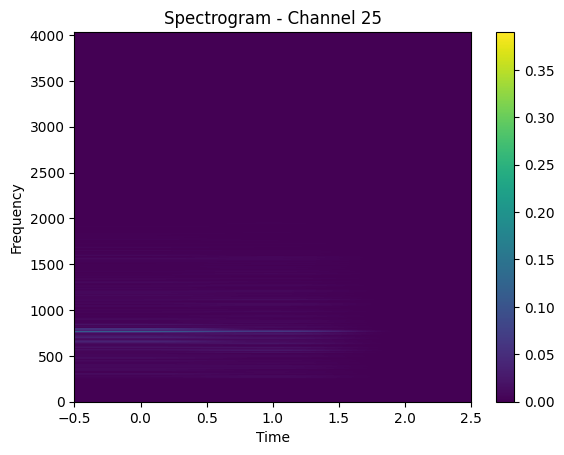

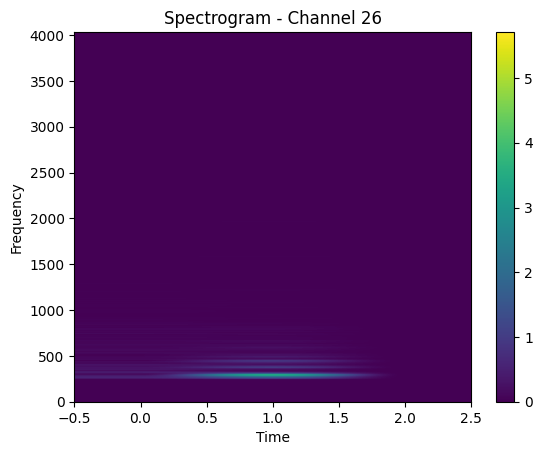

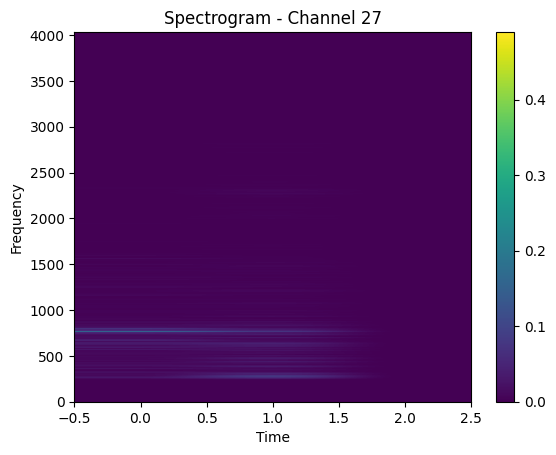

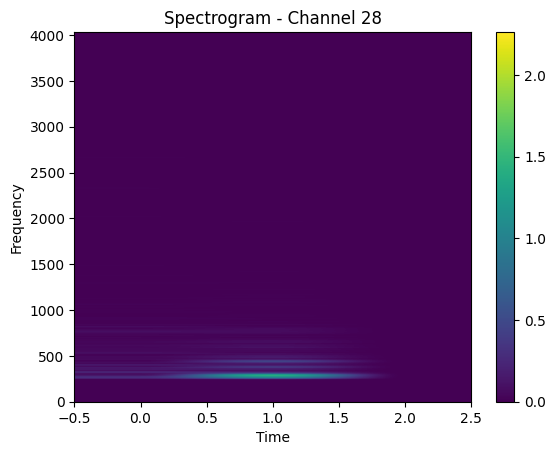

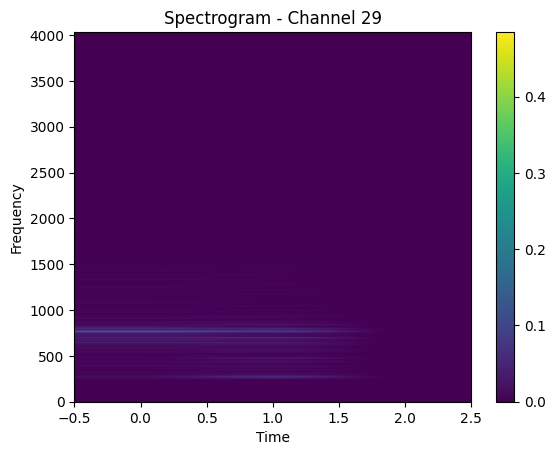

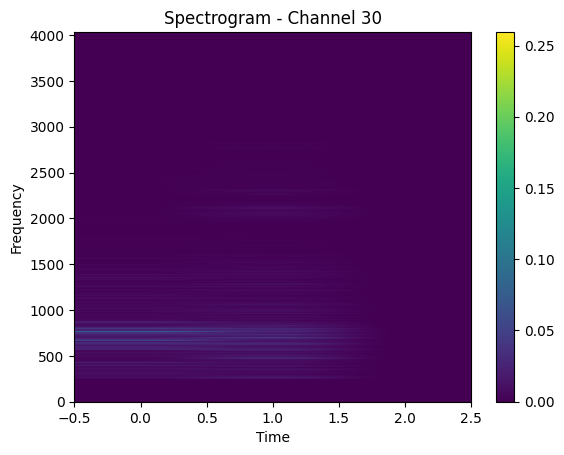

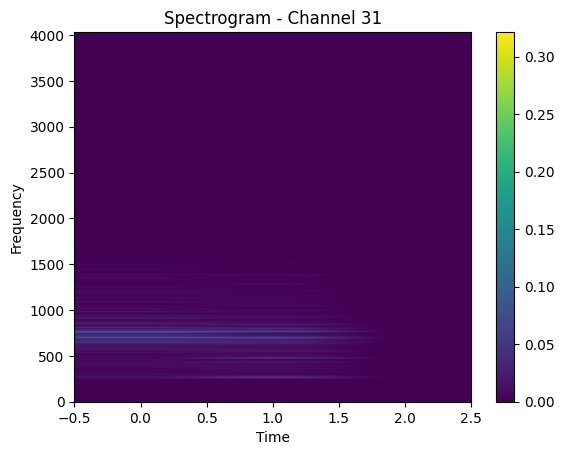

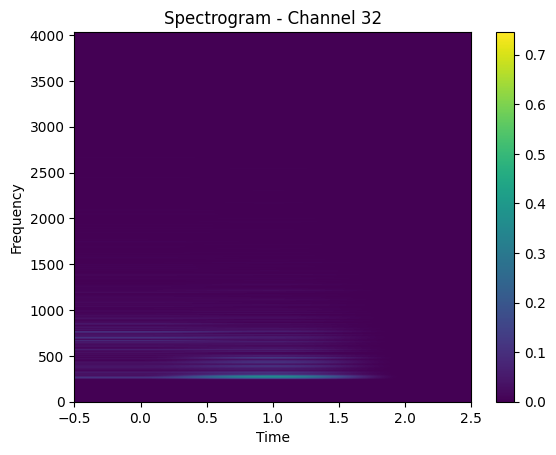

In [65]:
import matplotlib.pyplot as plt

sample = stft_train_data[0]

# Compute the magnitude squared of the complex STFT coefficients
spectrograms = np.abs(sample)**2

# Plot the spectrograms
for channel in range(num_channels):
    plt.figure()
    plt.imshow(spectrograms[channel], aspect='auto', origin='lower')
    plt.colorbar()
    plt.title(f'Spectrogram - Channel {channel+1}')
    plt.xlabel('Time')
    plt.ylabel('Frequency')
    plt.show()

In [66]:
from torch.utils.data import Dataset, TensorDataset

stft_train_data_final = np.abs(stft_train_data) ** 2
stft_test_data_final = np.abs(stft_test_data) ** 2

y_train = (y_train - np.min(y_train, axis = 0)) / (np.max(y_train, axis = 0) - np.min(y_train, axis = 0)) # from 0 to 1
y_train = 2 * y_train - 1 # from -1 to 1

y_test = (y_test - np.min(y_test, axis = 0)) / (np.max(y_test, axis = 0) - np.min(y_test, axis = 0)) # from 0 to 1
y_test = 2 * y_test - 1

train_dataset = TensorDataset(torch.tensor(stft_train_data_final).float(), torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(stft_test_data_final).float(), torch.tensor(y_test).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

In [113]:
stft_train_data_final.shape

(35, 32, 4033, 3)

In [67]:
from IPython.display import clear_output

def plot_losses(train_losses, test_losses):
    clear_output()
    fig, axs = plt.subplots(figsize=(13, 4))
    axs.plot(range(1, len(train_losses) + 1), train_losses, label='train')
    axs.plot(range(1, len(test_losses) + 1), test_losses, label='test')
    axs.set_ylabel('loss')
    axs.set_xlabel('epoch')
    axs.legend()

    plt.show()

In [135]:
import torch
import torch.nn as nn

class CRNN(nn.Module):
    def __init__(self, n_channels, gru_input_size = 4608):
        super(CRNN, self).__init__()
        
        # Convolutional layers
        self.conv = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        
        # Recurrent layers
        self.rnn = nn.GRU(input_size=gru_input_size, hidden_size=128, num_layers=3, batch_first=True)
        
        # Fully connected layers
        self.fc = nn.Linear(128, 2)
    
    def forward(self, x):
        # Apply convolutional layers
        x = x.permute(0, 3, 1, 2)
#         print(x.shape)
        conv_output = self.conv(x)
        print(conv_output.shape)
        # Reshape the output for the recurrent layers
        batch_size, _, height, width = conv_output.shape
        conv_output = conv_output.reshape(batch_size, _, height * width) # from DEAP
        conv_output[:, :, height * width : 8064] = 0 # pad sequence to match DEAP size
#         print(conv_output.shape)
        rnn_output, _ = self.rnn(conv_output)
        
        # Flatten the output for the fc
        rnn_output = rnn_output[:, -1, :]
        output = self.fc(rnn_output)
        
        return output

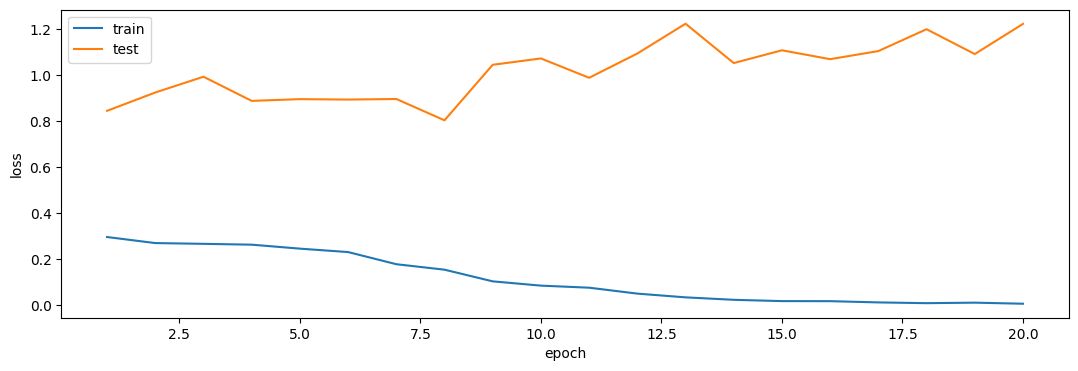

100%|███████████████████████████████████████████| 20/20 [02:15<00:00,  6.77s/it]


In [164]:
from tqdm import tqdm

model = CRNN(num_channels, 8064)
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
num_epochs = 20
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for spectrograms, targets in train_loader:
    
        optimizer.zero_grad()
        predictions = model(spectrograms)
        loss = loss_fn(predictions, targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= len(train_loader)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for spectrograms, targets in test_loader:
            predictions = model(spectrograms)
            test_loss += loss_fn(predictions, targets).item()

    test_loss /= len(test_loader)
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {test_loss:.4f}")
    plot_losses(train_losses, test_losses)

I suppose, data from spectrograms only is not enough. Makes sense. Now trying to apply cross-validation

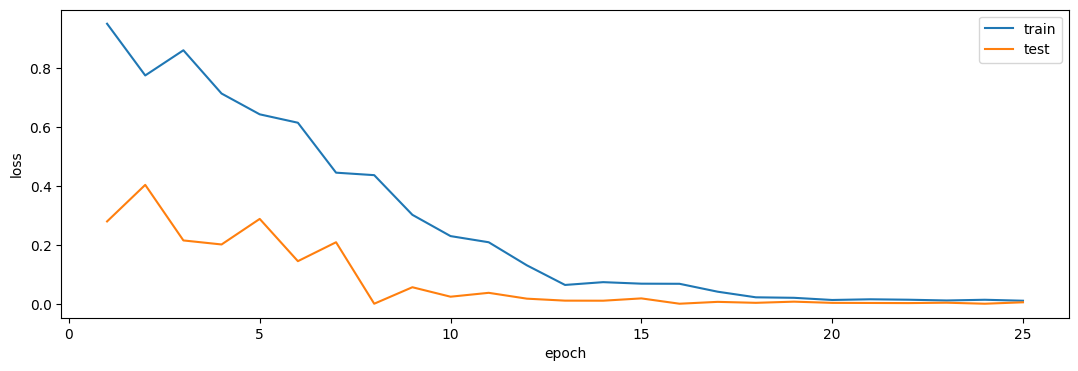

100%|███████████████████████████████████████████| 25/25 [04:08<00:00,  9.93s/it]


In [118]:
from tqdm import tqdm

all_data = torch.vstack((torch.tensor(stft_train_data_final).float(), 
                           torch.tensor(stft_test_data_final).float()))
all_labels = torch.vstack((torch.tensor(y_train).float(),
                          torch.tensor(y_test).float()))

dataset = TensorDataset(all_data, all_labels)

batch_size = 5

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

model = CRNN(num_channels)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for i, (spectrograms, targets) in enumerate(dataloader):
        if epoch % 8 == i:
            continue
        optimizer.zero_grad()
        predictions = model(spectrograms)
        loss = loss_fn(predictions, targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= (len(dataloader) - batch_size)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (spectrograms, targets) in enumerate(dataloader):
            if epoch % 8 == i:
                predictions = model(spectrograms)
                test_loss += loss_fn(predictions, targets).item()

#     test_loss /= batch_size
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {test_loss:.4f}")
    plot_losses(train_losses, test_losses)

In [137]:
import scipy
# Compute Power Spectral Density (PSD)
frequencies, X_train_psd = scipy.signal.welch(X_train, fs=fs)
frequencies, X_test_psd = scipy.signal.welch(X_test, fs=fs)

# Compute waveform characteristics
mean_value = np.mean(X_train, axis=1)
variance = np.var(X_train, axis=1)
peak_to_peak_amplitude = np.max(X_train, axis=1) - np.min(X_train, axis=1)
zero_crossing_rate = np.mean(np.diff(np.sign(X_train)))

In [141]:
from scipy import signal

# Define frequency bands of interest
bands = {
    'delta': (0.5, 4),
    'theta': (4, 8),
    'alpha': (8, 13),
    'beta': (13, 30),
    'gamma': (30, 100)
}

# Compute band power for each EEG recording
band_power = {}
for i, eeg_data in enumerate(X_train):
    # Compute Power Spectral Density (PSD)
    frequencies, psd = signal.welch(eeg_data, fs=fs)
    
    # Compute band power
    recording_band_power = {}
    for band_name, (f_low, f_high) in bands.items():
        # Find the indices of frequencies within the band
        indices = np.where(np.logical_and(frequencies >= f_low, frequencies < f_high))
        
        # Integrate the PSD within the band indices to get band power
        power = np.trapz(psd[:, indices], frequencies[indices], axis=-1)
        
        # Average the band power across channels
        recording_band_power[band_name] = np.mean(power, axis=0)
    
    # Store band power for the current recording
    band_power[f"Recording_{i+1}"] = recording_band_power


In [142]:
band_power['Recording_1']

{'delta': array([0.28050098]),
 'theta': array([60.74087637]),
 'alpha': array([28.15921619]),
 'beta': array([19.82257415]),
 'gamma': array([8.06444926])}

In [10]:
import pandas as pd

results = pd.read_csv('results.csv', index_col='Номер трека')
results.sort_index(inplace=True)

In [44]:
results.head()

,Номер записи,V,A
Номер трека,,,
1,DA0310F5,-0.3,0.7
2,DA0310EY,0.6,0.6
3,DA0310F1,0.1,0.4
4,DA0310F9,0.1,0.9
5,DA0310F2,0.3,0.5


In [24]:
real_valence_all = [-0.8, -0.8, 0.8, 0.8, -0.8, -0.8, 0.8, 0.8, -0.8, -0.8, -0.8, -0.8, 0.0, 0.8, 0.8, 0.8]
real_arousal_all = [-0.8, 0.8, -0.8, 0.8, -0.8, 0.8, -0.8, 0.8, -0.8, -0.8, 0.8, 0.8, 0.0, -0.8, 0.8, 0.8]

real_valence = [-0.8, -0.8, -0.8, -0.8, 0.0, 0.8, 0.8, 0.8]
real_arousal = [-0.8, -0.8, 0.8, 0.8, 0.0, -0.8, 0.8, 0.8]

predicted_valence = results.loc[25:]['V']
predicted_arousal = results.loc[25:]['A']

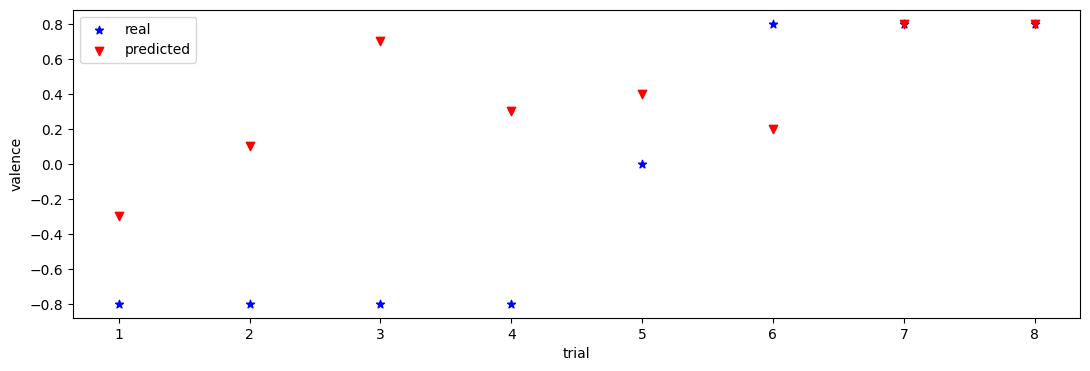

In [25]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(figsize=(13, 4))
# axs.plot(range(1, len(real_valence) + 1), real_valence, label='real')
# axs.plot(range(1, len(predicted_valence) + 1), predicted_valence, label='predicted')
plt.scatter(range(1, len(real_valence) + 1), real_valence, color='blue', marker= '*', label='real')
plt.scatter(range(1, len(predicted_valence) + 1), predicted_valence, color= 'red', marker='v', label='predicted')
axs.set_ylabel('valence')
axs.set_xlabel('trial')
axs.legend()
plt.show()

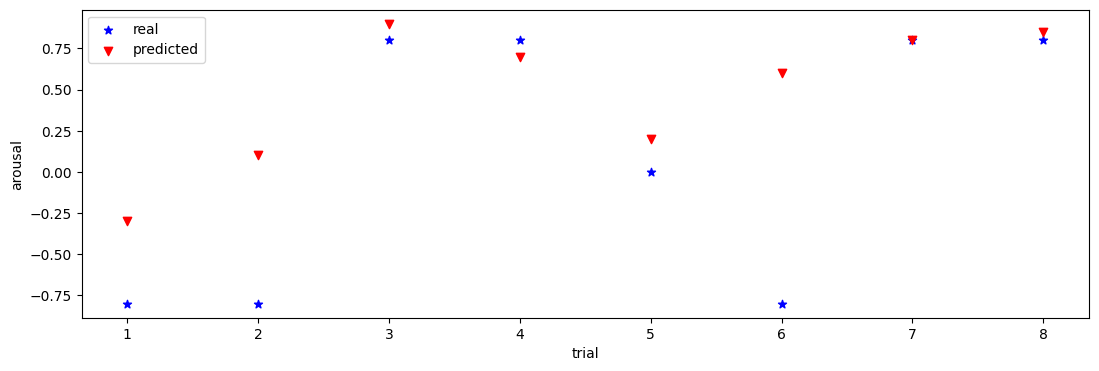

In [26]:
fig, axs = plt.subplots(figsize=(13, 4))
plt.scatter(range(1, len(real_arousal) + 1), real_arousal, color='blue', marker= '*', label='real')
plt.scatter(range(1, len(predicted_arousal) + 1), predicted_arousal, color= 'red', marker='v', label='predicted')
axs.set_ylabel('arousal')
axs.set_xlabel('trial')
axs.legend()
plt.show()

In [76]:
import os
import mne

eeg_data_folder = 'eeg-data-experiment/'

files = os.listdir(eeg_data_folder)
files = [file for file in files if file.endswith('.edf')]
files[0]

'DA0310EE_1-1+.edf'

In [77]:
raw = mne.io.read_raw_edf(os.path.join(eeg_data_folder, files[0]), preload=True)

print(raw.info)

Extracting EDF parameters from /Users/h1de0us/uni/coursework/eeg/eeg-data-experiment/DA0310EE_1-1+.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 35999  =      0.000 ...    35.999 secs...
<Info | 7 non-empty values
 bads: []
 ch_names: T7, TP9, P7, CP5, FT9, F7, FC5, F3, P3, C3, Fp1, FC1, Fz, Fp2, ...
 chs: 84 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 500.0 Hz
 meas_date: 2023-05-18 14:04:42 UTC
 nchan: 84
 projs: []
 sfreq: 1000.0 Hz
>


In [78]:
raw.filter(1, 40)

# resample the data to a desired sampling rate (128 Hz - DEAP-like resampling)
raw.resample(128)

# referencing the data to an average reference
raw.set_eeg_reference('average')

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 3301 samples (3.301 s)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  84 out of  84 | elapsed:    0.7s finished


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.


<RawEDF | DA0310EE_1-1+.edf, 84 x 4608 (36.0 s), ~3.0 MB, data loaded>

In [79]:
# from DEAP
channel_names = [
    'Fp1', 'AF3', 'F3', 'F7', 'FC5', 'FC1', 'C3', 'T7', 'CP5', 'CP1',
    'P3', 'P7', 'PO3', 'O1', 'Oz', 'Pz', 'Fp2', 'AF4', 'Fz', 'F4',
    'F8', 'FC6', 'FC2', 'Cz', 'C4', 'T8', 'CP6', 'CP2', 'P4', 'P8',
    'PO4', 'O2'
]

eeg_data = raw.get_data(picks=channel_names)
eeg_data

array([[ 3.21095521e-03, -4.84796725e-03, -1.17507806e-02, ...,
        -1.34110469e-04,  8.10542971e-05,  5.24896687e-05],
       [ 3.21230009e-03, -4.84993699e-03, -1.17526885e-02, ...,
        -1.40875055e-04,  7.13591174e-05,  2.89441290e-05],
       [ 3.21213799e-03, -4.84976420e-03, -1.17531674e-02, ...,
        -1.38823260e-04,  6.68064965e-05,  2.67616372e-05],
       ...,
       [ 3.20721855e-03, -4.84259990e-03, -1.17431640e-02, ...,
        -1.17053962e-04,  9.69658968e-05,  6.88753917e-05],
       [ 3.20313217e-03, -4.83668190e-03, -1.17346441e-02, ...,
        -1.23879220e-04,  7.14066521e-05,  5.05869764e-05],
       [ 3.20219306e-03, -4.83534083e-03, -1.17330751e-02, ...,
        -1.22844174e-04,  7.26636810e-05,  5.27130074e-05]])

In [80]:
eeg_data.shape

(32, 4608)

In [81]:
filenames = results.loc[25:]['Номер записи']
filenames

Номер трека
25    DA0310ES
26    DA0310EN
27    DA0310EJ
28    DA0310EQ
29    DA0310EO
30    DA0310EW
31    DA0310EP
32    DA0310EK
Name: Номер записи, dtype: object

In [98]:
from scipy.signal import stft

# Set the desired parameters for STFT
fs = 128  # Sampling frequency in Hz 
n_fft = 4608  # Number of FFT points
n_overlap = 128  # Number of overlapping samples

frequencies, time_points, stft_sample_data = stft(eeg_data, fs=fs, nperseg=n_fft, noverlap=n_overlap)
stft_sample_data.shape

(32, 2305, 3)

In [137]:
n_trials = 8
n_channels = 32
stft_data = np.ndarray((n_trials, n_channels, 2305, 3))  # 4033 to match DEAP

for i, filename in enumerate(filenames):
    file_path = os.path.join(eeg_data_folder, filename + '_1-1+.edf')
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
    raw.filter(1, 40, verbose=False)
    raw.resample(128, verbose=False)
    raw_copy = raw.copy().set_eeg_reference('average')
    eeg_data = raw_copy.get_data(picks=channel_names)
    frequencies, time_points, stft_sample_data = stft(eeg_data, fs=fs, nperseg=n_fft, noverlap=n_overlap)
    
    stft_data_final = np.abs(stft_sample_data) ** 2
    print(stft_data_final.shape)
    stft_data[i, :, :stft_sample_data.shape[1], :] = stft_sample_data
    stft_data[i, :, stft_sample_data.shape[1]:, :] = 0 # Pad sequence
    
# stft_data

EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(32, 2241, 3)


/var/folders/bb/tmb7sh8j2g735xnvcwh9yc7w0000gn/T/ipykernel_4308/1140890331.py:16: ComplexWarning: Casting complex values to real discards the imaginary part
  stft_data[i, :, :stft_sample_data.shape[1], :] = stft_sample_data


EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(32, 2241, 3)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(32, 2305, 3)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(32, 2241, 3)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(32, 2241, 3)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(32, 2241, 3)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(32, 2241, 3)
EEG channel type selected for re-referencing
Applying average reference.
Applying a custom ('EEG',) reference.
(32, 2305, 3)


In [138]:
stft_data.shape

(8, 32, 2305, 3)

In [131]:
from scipy.signal import stft

# Set the desired parameters for STFT
fs = 128  # Sampling frequency in Hz 
# (https://www.eecs.qmul.ac.uk/mmv/datasets/deap/readme.html#prep: the data was downsampled to 128 Hz)
n_fft = 4608  # Number of FFT points (from real data!!!!)
n_overlap = 128  # Number of overlapping samples

# Apply STFT to the EEG data
frequencies_train, time_points_train, stft_train_data = stft(X_train, fs=fs, nperseg=n_fft, noverlap=n_overlap)

frequencies_test, time_points_test, stft_test_data = stft(X_test, fs=fs, nperseg=n_fft, noverlap=n_overlap)

In [132]:
from torch.utils.data import Dataset, TensorDataset

stft_train_data_final = np.abs(stft_train_data) ** 2
stft_test_data_final = np.abs(stft_test_data) ** 2

y_train = (y_train - np.min(y_train, axis = 0)) / (np.max(y_train, axis = 0) - np.min(y_train, axis = 0)) # from 0 to 1
y_train = 2 * y_train - 1 # from -1 to 1

y_test = (y_test - np.min(y_test, axis = 0)) / (np.max(y_test, axis = 0) - np.min(y_test, axis = 0)) # from 0 to 1
y_test = 2 * y_test - 1

train_dataset = TensorDataset(torch.tensor(stft_train_data_final).float(), torch.tensor(y_train).float())
test_dataset = TensorDataset(torch.tensor(stft_test_data_final).float(), torch.tensor(y_test).float())

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=5, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=5, shuffle=False)

In [133]:
stft_train_data.shape

(35, 32, 2305, 3)

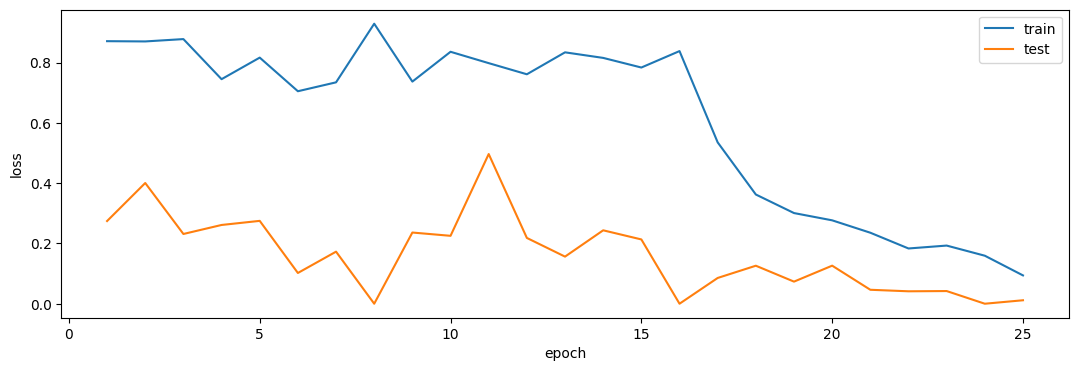

100%|███████████████████████████████████████████| 25/25 [01:35<00:00,  3.81s/it]


In [136]:
from tqdm import tqdm

all_data = torch.vstack((torch.tensor(stft_train_data_final).float(), 
                           torch.tensor(stft_test_data_final).float()))
all_labels = torch.vstack((torch.tensor(y_train).float(),
                          torch.tensor(y_test).float()))

dataset = TensorDataset(all_data, all_labels)

batch_size = 5

dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True) 

model = CRNN(num_channels)
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
num_epochs = 25
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs)

train_losses = []
test_losses = []

for epoch in tqdm(range(num_epochs)):
    model.train()
    train_loss = 0
    for i, (spectrograms, targets) in enumerate(dataloader):
        if epoch % 8 == i:
            continue
        optimizer.zero_grad()
        predictions = model(spectrograms)
        loss = loss_fn(predictions, targets)
        train_loss += loss.item()
        loss.backward()
        optimizer.step()
    train_loss /= (len(dataloader) - batch_size)
    train_losses.append(train_loss)

    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (spectrograms, targets) in enumerate(dataloader):
            if epoch % 8 == i:
                predictions = model(spectrograms)
                test_loss += loss_fn(predictions, targets).item()

#     test_loss /= batch_size
    test_losses.append(test_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Validation Loss: {test_loss:.4f}")
    plot_losses(train_losses, test_losses)

In [268]:
predictions = np.ndarray((8, 2))

for i, entry in enumerate(stft_data):
    with torch.no_grad():
        tensor = torch.tensor(entry).float().unsqueeze(dim=0)
        predictions[i, :] = model(tensor) # model was previously trained on DEAP
valence_model = predictions[:, 0]
arousal_model = predictions[:, 1]

torch.Size([1, 64, 8, 576])
torch.Size([1, 64, 8, 576])
torch.Size([1, 64, 8, 576])
torch.Size([1, 64, 8, 576])
torch.Size([1, 64, 8, 576])
torch.Size([1, 64, 8, 576])
torch.Size([1, 64, 8, 576])
torch.Size([1, 64, 8, 576])


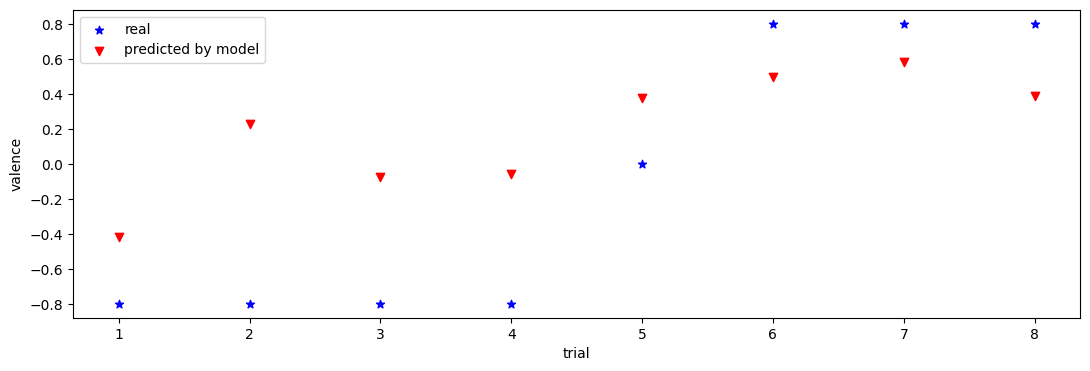

In [260]:

real_valence = [-0.8, -0.8, -0.8, -0.8, 0.0, 0.8, 0.8, 0.8]
real_arousal = [-0.8, -0.8, 0.8, 0.8, 0.0, -0.8, 0.8, 0.8]

fig, axs = plt.subplots(figsize=(13, 4))
# axs.plot(range(1, len(real_valence) + 1), real_valence, label='real')
# axs.plot(range(1, len(predicted_valence) + 1), predicted_valence, label='predicted')
plt.scatter(range(1, len(real_valence) + 1), real_valence, color='blue', marker= '*', label='real')
plt.scatter(range(1, len(valence_model) + 1), valence_model, color= 'red', marker='v', label='predicted by model')
axs.set_ylabel('valence')
axs.set_xlabel('trial')
axs.legend()
plt.show()

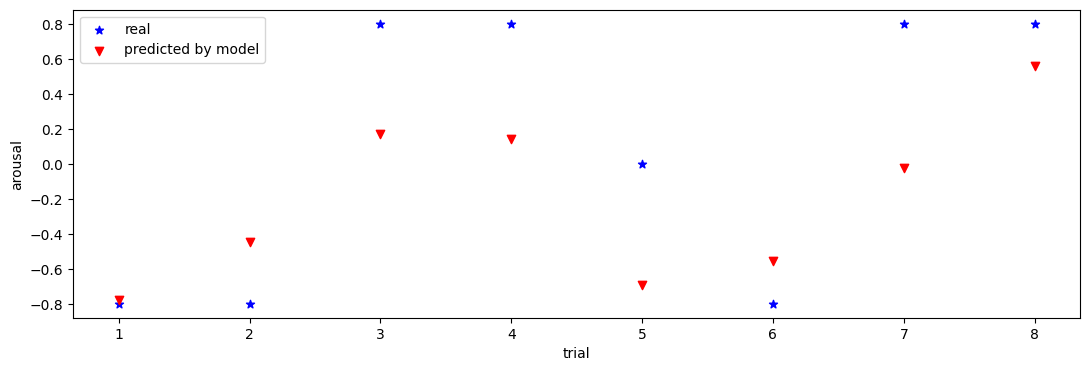

In [270]:
fig, axs = plt.subplots(figsize=(13, 4))
plt.scatter(range(1, len(real_arousal) + 1), real_arousal, color='blue', marker= '*', label='real')
plt.scatter(range(1, len(arousal_model) + 1), arousal_model, color= 'red', marker='v', label='predicted by model')
axs.set_ylabel('arousal')
axs.set_xlabel('trial')
axs.legend()
plt.show()

In [155]:
deap_scores = pd.read_csv('video_list.csv')
deap_scores.head()

,Online_id,Experiment_id,Lastfm_tag,Artist,Title,Youtube_link,Highlight_start,Num_ratings,VAQ_Estimate,VAQ_Online,...,AVG_Arousal,STD_Arousal,Q1_Arousal,Q2_Arousal,Q3_Arousal,AVG_Dominance,STD_Dominance,Q1_Dominance,Q2_Dominance,Q3_Dominance
0,1,NaN,happy,Alphabeat,Fascination,http://www.youtube.com/watch?v=QvD6maGRh7c,61,16,1,2,...,4.5625,2.3444,2.4167,4.5,7.0,5.2500,1.7139,5.0000,5.0,6.5833
1,2,1.0,fun,Emilíana Torrini,Jungle Drum,http://www.youtube.com/watch?v=iZ9vkd7Rp-g,81,14,1,1,...,5.8571,2.1993,4.0000,7.0,7.0,6.0000,1.5584,5.0000,6.0,7.0000
2,3,NaN,fun,The Go! Team,Huddle Formation,http://www.youtube.com/watch?v=X0eso4ARXzk,136,14,1,1,...,5.5714,2.0947,4.8333,6.0,7.0,5.5000,1.8420,5.0000,5.0,7.0000
3,4,NaN,fun,Junior Senior,Move Your Feet,http://www.youtube.com/watch?v=TjkQeBG8r_s,161,14,1,1,...,5.5000,2.2913,3.9167,6.0,8.0,5.0000,1.4142,4.9167,5.0,6.0000
4,5,NaN,fun,Of Montreal,Wraith Pinned To The Mist And Other Games,http://www.youtube.com/watch?v=7PoJv4N1Too,126,14,1,1,...,5.1429,1.4070,4.8333,5.0,6.0,4.9286,1.5336,4.9167,5.0,6.0000


In [165]:
online_ids = [7, 15, 62, 70, 88, 27, 83, 80]
valence_deap, arousal_deap = [], []
for idd in online_ids:
    valence_deap.append(deap_scores[deap_scores['Online_id'] == idd]['AVG_Valence'])
    arousal_deap.append(deap_scores[deap_scores['Online_id'] == idd]['AVG_Arousal'])
    

valence_deap = (valence_deap - np.min(valence_deap, axis = 0)) / (np.max(valence_deap, axis = 0) - np.min(valence_deap, axis = 0)) # from 0 to 1
valence_deap = 2 * valence_deap - 1 # from -1 to 1

arousal_deap = (arousal_deap - np.min(arousal_deap, axis = 0)) / (np.max(arousal_deap, axis = 0) - np.min(arousal_deap, axis = 0)) # from 0 to 1
arousal_deap = 2 * arousal_deap - 1 # from -1 to 1

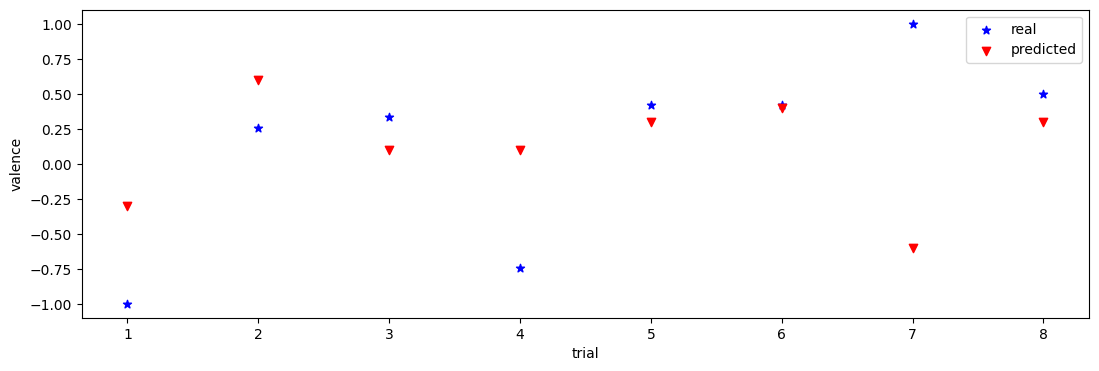

In [166]:
predicted_valence = results[:8]['V']

fig, axs = plt.subplots(figsize=(13, 4))
plt.scatter(range(1, len(valence_deap) + 1), valence_deap, color='blue', marker= '*', label='real')
plt.scatter(range(1, len(predicted_valence) + 1), predicted_valence, color= 'red', marker='v', label='predicted')
axs.set_ylabel('valence')
axs.set_xlabel('trial')
axs.legend()
plt.show()

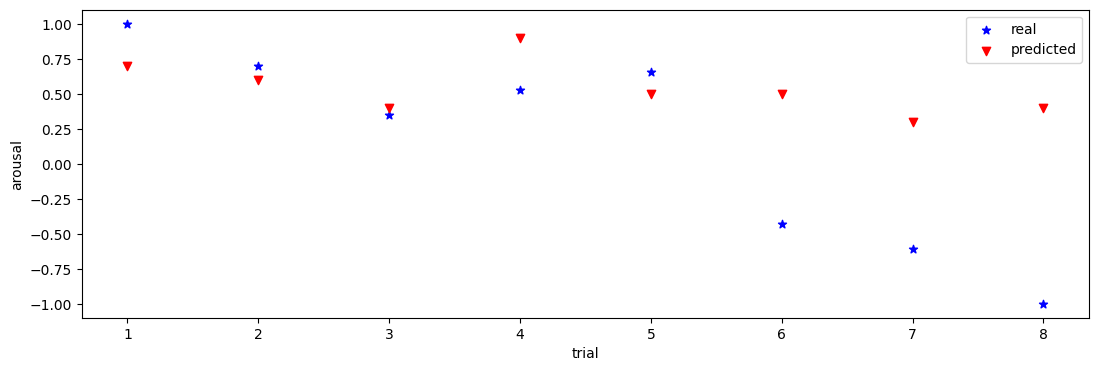

In [167]:
predicted_arousal = results[:8]['A']

fig, axs = plt.subplots(figsize=(13, 4))
plt.scatter(range(1, len(arousal_deap) + 1), arousal_deap, color='blue', marker= '*', label='real')
plt.scatter(range(1, len(predicted_arousal) + 1), predicted_arousal, color= 'red', marker='v', label='predicted')
axs.set_ylabel('arousal')
axs.set_xlabel('trial')
axs.legend()
plt.show()